In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import replicaEVSE.load_curve as sim
import replicaEVSE.visualizations as viz
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

datadir = '../../data/'

In [2]:
charge_file = 'charges_PRIVATE_AUTO_base_dev_with_ldv_logic_2021_20230528.parquet'
charges = pd.read_parquet(datadir + charge_file)

load_file = 'loads_PRIVATE_AUTO_base_dev_with_ldv_logic_2021_20230528.parquet'
loads = pd.read_parquet(datadir + load_file)

In [10]:
charges.charge_type.value_counts()

charge_type
public                 571484
single_family_home     297082
multi_family_home       74044
non_office_work         51999
office                  43030
mobile_home             21835
civic_institutional      7987
Name: count, dtype: int64

# There might be a problem with the loads not populating all the charges...

In [3]:
charges[charges['charger_power_kW']> 0]

,person_id,charge_id,charge_type,activity_id,simulation_id,charger_power_kW,charge_energy_used_kWh,charge_opportunity_remaining_kWh
0,13033034909424887242,14321003733064875798_base_dev_with_ldv_logic_2...,public,14321003733064875798,base_dev_with_ldv_logic_2021_20230528,19.0,15.907542,4.364403
2,13033034909424887242,17829357849169262043_base_dev_with_ldv_logic_2...,public,17829357849169262043,base_dev_with_ldv_logic_2021_20230528,150.0,0.000000,333.833333
3,13033034909424887242,10953296267373851493_base_dev_with_ldv_logic_2...,public,10953296267373851493,base_dev_with_ldv_logic_2021_20230528,150.0,0.000000,87.541667
4,13033034909424887242,13432609425461555417_base_dev_with_ldv_logic_2...,public,13432609425461555417,base_dev_with_ldv_logic_2021_20230528,150.0,8.053364,2093.988303
0,13048677201231373340,587308997879437542_base_dev_with_ldv_logic_202...,public,587308997879437542,base_dev_with_ldv_logic_2021_20230528,150.0,0.000000,46.000000
...,...,...,...,...,...,...,...,...
4,4711507539674741230,15936646075120558469_base_dev_with_ldv_logic_2...,single_family_home,15936646075120558469,base_dev_with_ldv_logic_2021_20230528,7.2,14.223076,89.526924
0,5530762753836780549,7126426115946094897_base_dev_with_ldv_logic_20...,public,7126426115946094897,base_dev_with_ldv_logic_2021_20230528,19.0,0.000000,17.184444
1,5530762753836780549,10593498088852015349_base_dev_with_ldv_logic_2...,single_family_home,10593498088852015349,base_dev_with_ldv_logic_2021_20230528,7.2,18.680055,139.099945
0,9287904891057512086,8756993855200803501_base_dev_with_ldv_logic_20...,public,8756993855200803501,base_dev_with_ldv_logic_2021_20230528,150.0,0.000000,69.583333


In [4]:
charges[charges['person_id'] == '13033034909424887242']

,person_id,charge_id,charge_type,activity_id,simulation_id,charger_power_kW,charge_energy_used_kWh,charge_opportunity_remaining_kWh
0,13033034909424887242,14321003733064875798_base_dev_with_ldv_logic_2...,public,14321003733064875798,base_dev_with_ldv_logic_2021_20230528,19.0,15.907542,4.364403
1,13033034909424887242,12881855298055908914_base_dev_with_ldv_logic_2...,non_office_work,12881855298055908914,base_dev_with_ldv_logic_2021_20230528,0.0,0.000000,0.000000
2,13033034909424887242,17829357849169262043_base_dev_with_ldv_logic_2...,public,17829357849169262043,base_dev_with_ldv_logic_2021_20230528,150.0,0.000000,333.833333
3,13033034909424887242,10953296267373851493_base_dev_with_ldv_logic_2...,public,10953296267373851493,base_dev_with_ldv_logic_2021_20230528,150.0,0.000000,87.541667
4,13033034909424887242,13432609425461555417_base_dev_with_ldv_logic_2...,public,13432609425461555417,base_dev_with_ldv_logic_2021_20230528,150.0,8.053364,2093.988303


In [5]:
charges['charge_id'].values[0]

'14321003733064875798_base_dev_with_ldv_logic_2021_20230528'

In [6]:
# trips[(trips['person_id'] == '13033034909424887242') & (trips['weekday'] == 'thursday')]

### have a column for charging type thats less specific

In [7]:
charges['location'] = charges.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
charges['location'] = charges['location'].where(charges['location'].isin(keep_values), 'work')
charges['location'] = charges['location'].where(charges['location'].isin(home_values), 'home')
charges['location'].unique()

array(['public', 'work', 'home'], dtype=object)

### Fraction of charging events of each type. 

location
public    0.628325
home      0.344546
work      0.027128
Name: count, dtype: float64

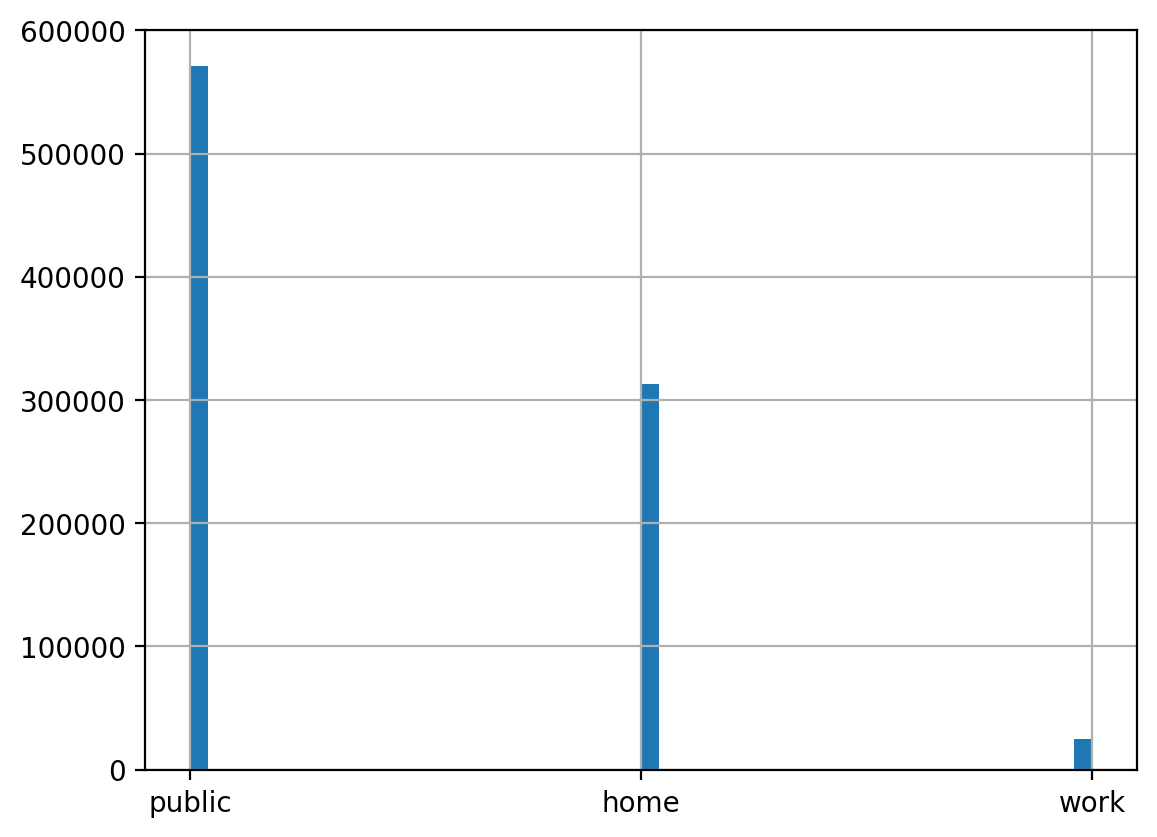

In [8]:
charges[charges['charger_power_kW'] > 0]['location'].hist(bins=50)
charges[charges['charger_power_kW'] > 0]['location'].value_counts()/len(charges[charges['charger_power_kW'] > 0])

In [11]:

reftime = ref_time=dt.datetime(2023, 1, 1, 0, 0)
loads["hour"] = (loads["window_end_time"]+ref_time).dt.hour

In [12]:
trips = pd.read_parquet(datadir + 'wa_pop_and_trips_sorted.parquet')
trips.drop(columns=['charge_type'])

,activity_id,person_id,mode,travel_purpose,previous_activity_type,start_time,end_time,distance_miles,vehicle_type,origin_bgrp,...,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh
__null_dask_index__,,,,,,,,,,,,,,,,,,,,,
0,18336634547462657450,10000002909730821040,PRIVATE_AUTO,SOCIAL,HOME,0 days 08:20:42,0 days 08:39:00,2.897196,nan,530250111002,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
1,1694659094182985471,10000002909730821040,PRIVATE_AUTO,HOME,SOCIAL,0 days 09:12:45,0 days 09:19:56,2.867602,nan,530250111003,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
2,7721623352602932778,10000002909730821040,ON_DEMAND_AUTO,SHOP,HOME,0 days 09:30:08,0 days 09:49:04,8.929170,nan,530250111002,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
3,3697919619727259534,10000002909730821040,CARPOOL,SHOP,SHOP,0 days 09:54:21,0 days 09:57:14,0.996870,nan,530250109022,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
4,9977271661694103189,10000002909730821040,WALKING,SHOP,SHOP,0 days 10:23:28,0 days 10:25:01,0.080298,nan,530250111001,...,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176294,17390194002376271909,129762667123447258,PRIVATE_AUTO,SHOP,HOME,0 days 18:08:13,0 days 18:15:40,3.283053,nan,530330303102,...,single_family,core,english,47.291426,-122.343578,47.300378,-122.359055,NaN,NaN,worked_from_home
176295,884521432970543080,129762667123447258,PRIVATE_AUTO,SHOP,SHOP,0 days 18:22:16,0 days 18:25:16,0.749009,nan,530330303141,...,single_family,core,english,47.291426,-122.343578,47.300378,-122.359055,NaN,NaN,worked_from_home
176296,7536433276779622397,129762667123447258,PRIVATE_AUTO,HOME,SHOP,0 days 18:48:28,0 days 18:56:31,3.582652,nan,530330300062,...,single_family,core,english,47.291426,-122.343578,47.300378,-122.359055,NaN,NaN,worked_from_home


In [11]:
charges = charges[['person_id', 'charge_id', 'charge_type', 'activity_id', 'charger_power_kW']]
loads = loads[['charge_id', 'load_kW', 'window_start_time','window_end_time']]
reftime = ref_time=dt.datetime(2023, 1, 1, 0, 0)
loads["hour"] = (loads["window_end_time"]+ref_time).dt.hour

TODO: VMT vs total distance/efficiency 

In [12]:
loadscharges = loads.merge(charges, on='charge_id', how='left')

In [13]:
loadscharges

,charge_id,load_kW,window_start_time,window_end_time,hour,person_id,charge_type,activity_id,charger_power_kW
0,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 00:00:00,0 days 01:00:00,1,13033034909424887242,public,14321003733064875798,19.0
1,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 01:00:00,0 days 02:00:00,2,13033034909424887242,public,14321003733064875798,19.0
2,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 02:00:00,0 days 03:00:00,3,13033034909424887242,public,14321003733064875798,19.0
3,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 03:00:00,0 days 04:00:00,4,13033034909424887242,public,14321003733064875798,19.0
4,14321003733064875798_base_dev_with_ldv_logic_2...,0.0,0 days 04:00:00,0 days 05:00:00,5,13033034909424887242,public,14321003733064875798,19.0
...,...,...,...,...,...,...,...,...,...
9427003,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 19:00:00,0 days 20:00:00,20,9287904891057512086,single_family_home,16727905968817968301,7.2
9427004,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 20:00:00,0 days 21:00:00,21,9287904891057512086,single_family_home,16727905968817968301,7.2
9427005,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 21:00:00,0 days 22:00:00,22,9287904891057512086,single_family_home,16727905968817968301,7.2
9427006,16727905968817968301_base_dev_with_ldv_logic_2...,0.0,0 days 22:00:00,0 days 23:00:00,23,9287904891057512086,single_family_home,16727905968817968301,7.2


In [14]:
all = loadscharges.merge(trips, on='activity_id', how='left')

In [15]:
len(all), len(charges['activity_id'].unique()), len(trips)

(9427008, 1067461, 51727268)

In [16]:
all[(all['weekday'] == 'thursday') & (all['mode'] == 'PRIVATE_AUTO')]['distance_miles'].sum()

46546477.03002776

In [17]:
trips[(trips['weekday'] == 'thursday') & (trips['mode'] == 'PRIVATE_AUTO')]['distance_miles'].sample(frac=0.05).sum()

6684474.390331035

Maybe the stops < 10 mins are the issue? I wonder how many of them there are. 

In [ ]:
def add_stop_duration_to_trips(trips):
    for j in trips.sample(frac=0.05).person_id.unique():
        trips_temp = trips.loc[trips.person_id == j].copy()
        trips_temp = trips_temp[(trips_temp['weekday'] == 'thursday') & (trips_temp['mode'] == 'PRIVATE_AUTO')].copy()
        if len(trips_temp) > 0:
            trips_temp = sim.calculate_stop_duration(trips_temp)
            trips_temp = trips_temp.loc[trips_temp['stop_duration'] > pd.to_timedelta('10 minutes')]
if False:
    
    df_list = np.array_split(trips, 10000)
    import joblib
    trips = joblib.Parallel(verbose=10, n_jobs=-1
                            )(joblib.delayed(
                                add_stop_duration_to_trips)(
                                    df_i)
                            )                                                                                              ) 
        for df_i in df_list)

In [18]:
all.drop(columns=['person_id_y', 'charge_type_y'], inplace=True)
all.rename(columns={'person_id_x': 'person_id', 'charge_type_x': 'charge_type'}, inplace=True)

I dont see that other charging event for the loads...maybe it was on a different day. 

In [19]:
all[(all['person_id'] == '13033034909424887242') & (all['weekday'] == 'thursday')]

,charge_id,load_kW,window_start_time,window_end_time,hour,person_id,charge_type,activity_id,charger_power_kW,mode,...,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh
0,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 00:00:00,0 days 01:00:00,1,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
1,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 01:00:00,0 days 02:00:00,2,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
2,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 02:00:00,0 days 03:00:00,3,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
3,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 03:00:00,0 days 04:00:00,4,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
4,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 04:00:00,0 days 05:00:00,5,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
5,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 05:00:00,0 days 06:00:00,6,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
6,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 06:00:00,0 days 07:00:00,7,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
7,14321003733064875798_base_dev_with_ldv_logic_2...,14.202500,0 days 07:00:00,0 days 08:00:00,8,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
8,14321003733064875798_base_dev_with_ldv_logic_2...,1.705042,0 days 08:00:00,0 days 09:00:00,9,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf
9,14321003733064875798_base_dev_with_ldv_logic_2...,0.000000,0 days 09:00:00,0 days 10:00:00,10,13033034909424887242,public,14321003733064875798,19.0,PRIVATE_AUTO,...,single_family,core,english,47.136017,-119.357276,NaN,NaN,NaN,NaN,under_16_or_notinlf


### Prepare the data by extracting load curve lists for each of the catagories

In [20]:

df = all.copy()
df['location'] = df.charge_type.copy()
keep_values = ['single_family_home', 'multi_family_home', 'public']
home_values = ['public', 'work']

# Set values not in the keep list to 'work'
df['location'] = df['location'].where(df['location'].isin(keep_values), 'work')
df['location'] = df['location'].where(df['location'].isin(home_values), 'home')


locations = ['home', 'public', 'work',]
df_list_thu, df_list_sat = viz.extract_load_curve(df, locations=locations)


### Commercial load curves
sat_commercial = pd.read_csv(datadir + 'saturday_loads_commercial.csv')
thu_commercial = pd.read_csv(datadir + 'thursday_loads_commercial.csv')

# pull out the load curves for the commercial locations
thu_mdv = thu_commercial['load_mdv'].to_list()
thu_hdv = thu_commercial['load_hdv'].to_list()
sat_mdv = sat_commercial['mdv_load'].to_list()
sat_hdv = sat_commercial['hdv_load'].to_list()

# add the residential load curves
df_list_thu, df_list_sat = viz.extract_load_curve(df, locations=locations)

# stack on the 
df_list_thu.append(thu_mdv)
df_list_thu.append(thu_hdv)
df_list_sat.append(sat_mdv)
df_list_sat.append(sat_hdv)

# Convert to numpy arrays and convert to MW
thu_loads = [np.array(ll)/1e3 for ll in df_list_thu]
sat_loads = [np.array(ll)/1e3 for ll in df_list_sat]


# this is useful for trouble shooting. 
# can fail if the location names are not correct
# for ll in df_list_thu:
#     print(len(ll))

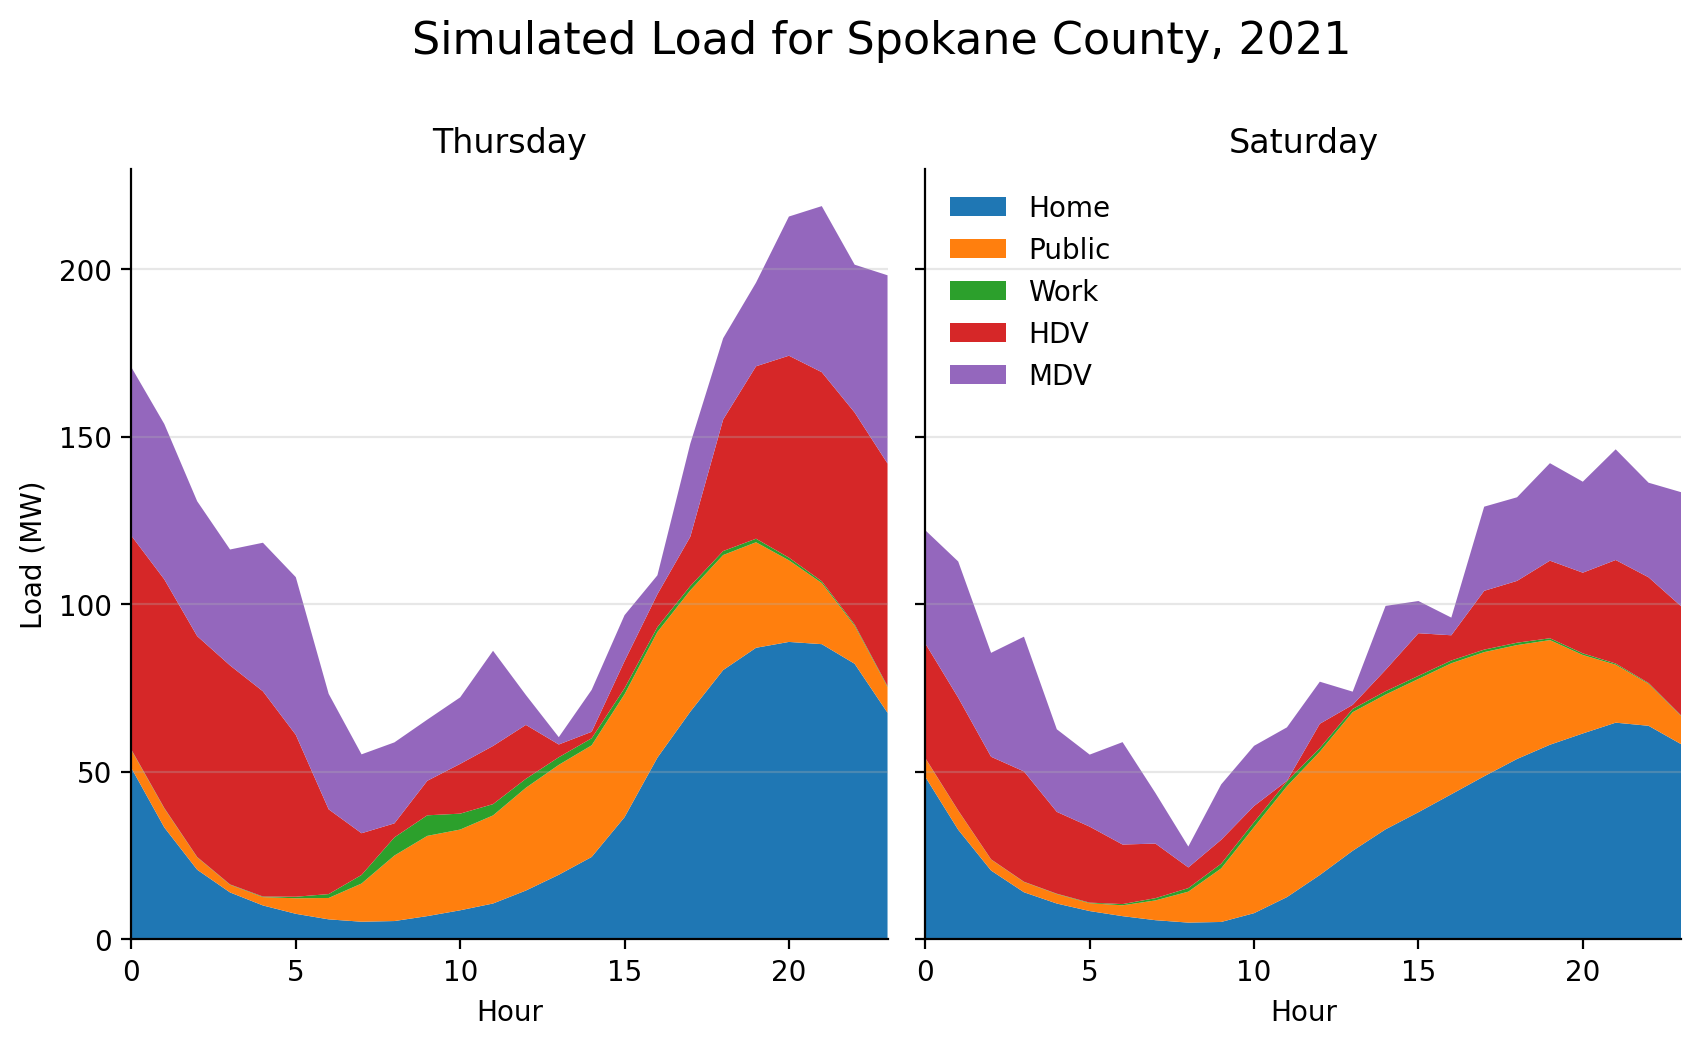

In [27]:
locations = ['home', 'public', 'work',]
fig, axes = viz.make_load_curve_plot(thu_loads, sat_loads, locations, loc_label='Spokane')


The percentage of peak load associated with each charger:

In [23]:
def load_frac_by_loc(df, day='thursday', hour=19):
    df_thu = df.loc[(df.weekday == day)& (df['hour'] == hour)].copy()
    df_peak_load = df_thu.groupby(by=['location']).sum()
    total_load = df_peak_load.load_kW.sum()
    df_peak_load['load_frac_by_loc'] = df_peak_load.load_kW/total_load
    df_peak_load[['location', 'load_frac_by_loc']]
    print("peak load: ", total_load)
    return df_peak_load[['location', 'load_frac_by_loc']]

load_frac_by_loc(df, day='thursday', hour=19)


,location,load_frac_by_loc
0,home,0.727812
1,public,0.263318
2,work,0.008870


### sanity check: how many cars charging during peak?

In [36]:
# df_sub = df.groupby(by=['weekday', 'location', 'hour']).sum().reset_index()

In [37]:
df_thu = df.loc[(df.weekday=='thursday')].copy()
peakdf = df_thu[(df_thu['hour'] == 19)]
tot = len(peakdf)
peakdf['charge_type'].value_counts()/tot

charge_type
single_family_home     0.8
civic_institutional    0.2
Name: count, dtype: float64

In [38]:
df_sub

,weekday,location,hour,charge_id,load_kW,window_start_time,window_end_time,person_id,charge_type,activity_id,...,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh
0,saturday,home,0,2629818508449797265_base_dev_with_ldv_logic_20...,13.756000,10 days 13:00:00,11 days 00:00:00,1371733387649355059715003737673849124496177285...,single_family_homesingle_family_homesingle_fam...,2629818508449797265979741021509621901713853263...,...,single_familysingle_familysingle_familysingle_...,corecorecorecorecorecorecorecorecorecorecore,englishenglishenglishenglishenglishenglishengl...,524.720481,-1292.132016,333.647597,-821.626450,143.099386,-352.285198,worked_in_personworked_in_personworked_in_pers...
1,saturday,home,1,2629818508449797265_base_dev_with_ldv_logic_20...,8.999379,0 days 00:00:00,0 days 11:00:00,1371733387649355059715003737673849124496177285...,single_family_homesingle_family_homesingle_fam...,2629818508449797265979741021509621901713853263...,...,single_familysingle_familysingle_familysingle_...,corecorecorecorecorecorecorecorecorecorecore,englishenglishenglishenglishenglishenglishengl...,524.720481,-1292.132016,333.647597,-821.626450,143.099386,-352.285198,worked_in_personworked_in_personworked_in_pers...
2,saturday,home,2,2629818508449797265_base_dev_with_ldv_logic_20...,3.006250,0 days 11:00:00,0 days 22:00:00,1371733387649355059715003737673849124496177285...,single_family_homesingle_family_homesingle_fam...,2629818508449797265979741021509621901713853263...,...,single_familysingle_familysingle_familysingle_...,corecorecorecorecorecorecorecorecorecorecore,englishenglishenglishenglishenglishenglishengl...,524.720481,-1292.132016,333.647597,-821.626450,143.099386,-352.285198,worked_in_personworked_in_personworked_in_pers...
3,saturday,home,3,2629818508449797265_base_dev_with_ldv_logic_20...,0.000000,0 days 22:00:00,1 days 09:00:00,1371733387649355059715003737673849124496177285...,single_family_homesingle_family_homesingle_fam...,2629818508449797265979741021509621901713853263...,...,single_familysingle_familysingle_familysingle_...,corecorecorecorecorecorecorecorecorecorecore,englishenglishenglishenglishenglishenglishengl...,524.720481,-1292.132016,333.647597,-821.626450,143.099386,-352.285198,worked_in_personworked_in_personworked_in_pers...
4,saturday,home,4,2629818508449797265_base_dev_with_ldv_logic_20...,0.000000,1 days 09:00:00,1 days 20:00:00,1371733387649355059715003737673849124496177285...,single_family_homesingle_family_homesingle_fam...,2629818508449797265979741021509621901713853263...,...,single_familysingle_familysingle_familysingle_...,corecorecorecorecorecorecorecorecorecorecore,englishenglishenglishenglishenglishenglishengl...,524.720481,-1292.132016,333.647597,-821.626450,143.099386,-352.285198,worked_in_personworked_in_personworked_in_pers...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,thursday,work,19,11486672046359089333_base_dev_with_ldv_logic_2...,0.000000,3 days 00:00:00,3 days 04:00:00,1395219338880550829032462245133231356915134137...,civic_institutionalcivic_institutionalcivic_in...,1148667204635908933316223972040068285021222848...,...,single_familymultiple_unitsseveral_unitssingle...,corecorecorecore,englishenglishenglishenglish,190.680320,-470.269446,190.807306,-469.851405,0.000000,0.000000,worked_in_personworked_in_personworked_in_pers...
68,thursday,work,20,11486672046359089333_base_dev_with_ldv_logic_2...,0.000000,3 days 04:00:00,3 days 08:00:00,1395219338880550829032462245133231356915134137...,civic_institutionalcivic_institutionalcivic_in...,1148667204635908933316223972040068285021222848...,...,single_familymultiple_unitsseveral_unitssingle...,corecorecorecore,englishenglishenglishenglish,190.680320,-470.269446,190.807306,-469.851405,0.000000,0.000000,worked_in_personworked_in_personworked_in_pers...
69,thursday,work,21,11486672046359089333_base_dev_with_ldv_logic_2...,0.000000,3 days 08:00:00,3 days 12:00:00,139521

In [39]:
len(df_thu), len(df_thu['person_id'].unique())

(480, 20)

In [40]:
peak_kw = df_thu[(df_thu['hour'] == 19) & (df_thu['load_kW'] > 0)]['load_kW'].sum()
num_cars = df_thu[(df_thu['hour'] == 19) & (df_thu['load_kW'] > 0)]['person_id'].unique().shape[0]
peak_kw/num_cars

/tmp/ipykernel_32805/3202738506.py:3: RuntimeWarning: invalid value encountered in scalar divide
  peak_kw/num_cars


nan